In [1]:
import os
from os.path import splitext

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
from torchvision import transforms
from torchvision.models import DenseNet121_Weights

### Not sure what this is

In [2]:
folder = 'mip_group_2/CheXpert Plus'

In [ ]:
df = pd.read_json(os.path.join(folder, "report_fixed.json"), lines=True)

In [ ]:
type_list = []
for path in df['path_to_image']:
    type_list.append(splitext(path)[0].split('/')[0])

In [26]:
np.unique(type_list, return_counts=True)

(array(['train', 'valid'], dtype='<U5'), array([223228,    234]))

### Checkout what's inside data folder

In [2]:
data_folder = '../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus'

In [3]:
os.listdir(data_folder)

['chexbert_labels.zip',
 'radgraph-XL-annotations',
 'PNG',
 'radgraph-XL-annotations.zip',
 'chexbert_labels',
 'df_chexpert_plus_240401.csv']

#### looks at how patients' images are split and stored in the folders

In [4]:
img_folder_path = os.path.join(data_folder, 'PNG')

In [5]:
img_folders = [folder for folder in os.listdir(img_folder_path) if splitext(folder)[1] == '']

In [6]:
img_folders

['png_chexpert_plus_chunk_0',
 'png_chexpert_plus_chunk_1',
 'png_chexpert_plus_chunk_3',
 'png_chexpert_plus_chunk_4',
 'png_chexpert_plus_chunk_2']

In [7]:
for folder in img_folders:
    img_subfolder = os.path.join(img_folder_path, folder)
    img_subfolder = os.path.join(img_subfolder, 'PNG')
    img_subfolder = os.path.join(img_subfolder, 'train')
    print(len(os.listdir(img_subfolder)))

5868
8171
18728
19722
12038


#### folder that has labels for data

In [8]:
os.listdir(os.path.join(data_folder, 'chexbert_labels'))

['report_fixed.json', 'findings_fixed.json', 'impression_fixed.json']

In [9]:
label_folder = os.path.join(data_folder, 'chexbert_labels')

#### paths of the input images and their labels

In [10]:
import json

file_path = os.path.join(label_folder, 'findings_fixed.json')

with open(file_path, 'r') as f:
    data = []
    for line in f:
        data.append(json.loads(line))  # Load each JSON object separately


for i in range(200, 205, 1):
    print(data[i])

{'path_to_image': 'train/patient16523/study1/view2_lateral.jpg', 'Enlarged Cardiomediastinum': None, 'Cardiomegaly': None, 'Lung Opacity': None, 'Lung Lesion': None, 'Edema': None, 'Consolidation': None, 'Pneumonia': None, 'Atelectasis': None, 'Pneumothorax': None, 'Pleural Effusion': None, 'Pleural Other': None, 'Fracture': None, 'Support Devices': None, 'No Finding': 1.0}
{'path_to_image': 'train/patient16523/study11/view1_frontal.jpg', 'Enlarged Cardiomediastinum': None, 'Cardiomegaly': None, 'Lung Opacity': None, 'Lung Lesion': None, 'Edema': None, 'Consolidation': None, 'Pneumonia': None, 'Atelectasis': None, 'Pneumothorax': None, 'Pleural Effusion': None, 'Pleural Other': None, 'Fracture': None, 'Support Devices': None, 'No Finding': 1.0}
{'path_to_image': 'train/patient16523/study16/view1_frontal.jpg', 'Enlarged Cardiomediastinum': None, 'Cardiomegaly': None, 'Lung Opacity': None, 'Lung Lesion': None, 'Edema': None, 'Consolidation': None, 'Pneumonia': None, 'Atelectasis': None, 

In [11]:
data[0]['path_to_image']

'train/patient42142/study5/view1_frontal.jpg'

In [12]:
len(data)

223462

In [13]:
data[0].items()

dict_items([('path_to_image', 'train/patient42142/study5/view1_frontal.jpg'), ('Enlarged Cardiomediastinum', None), ('Cardiomegaly', None), ('Lung Opacity', None), ('Lung Lesion', None), ('Edema', None), ('Consolidation', None), ('Pneumonia', None), ('Atelectasis', None), ('Pneumothorax', None), ('Pleural Effusion', None), ('Pleural Other', None), ('Fracture', None), ('Support Devices', None), ('No Finding', 1.0)])

#### see how many patients there are

In [15]:
int(splitext(data[0]['path_to_image'])[0].split('/')[1][7:])

42142

[    1     2     3 ... 64738 64739 64740]


(array([40329., 14561.,  4724.,  2150.,  1082.,   593.,   431.,   242.,
          177.,    97.,    72.,    61.,    46.,    46.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30., 33., 36.,
        39., 42.]),
 <BarContainer object of 14 artists>)

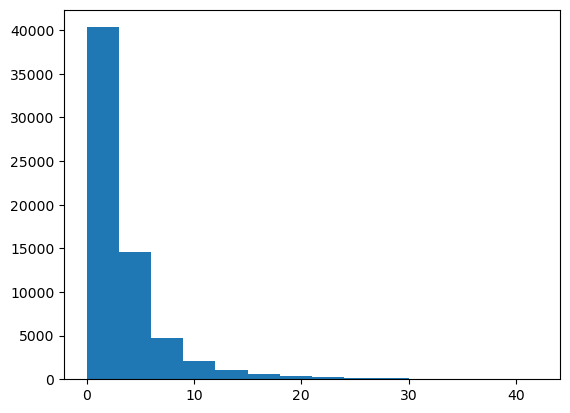

In [25]:
patient_list = []
for entry_dict in data:
    patient_list.append(int(splitext(entry_dict['path_to_image'])[0].split('/')[1][7:]))
uniq_patient_list, uniq_patient_cnt = np.unique(patient_list, return_counts=True)
print(uniq_patient_list)
plt.hist(uniq_patient_cnt, bins=np.arange(0, 45, 3))

#### open and transform the image files

In [23]:
transform = DenseNet121_Weights.DEFAULT.transforms()

In [24]:
for key, value in data[0].items():
    if key == 'path_to_image': # save image paths
        if splitext(value)[0].split('/')[0] == 'train':
            value = splitext(value)[0] + '.png'
            for folder in img_folders:
                img_subfolder_path = os.path.join(os.path.join(img_folder_path, folder), 'PNG')
                full_img_path = os.path.join(img_subfolder_path, value)
                if os.path.exists(full_img_path):
                    img = Image.open(full_img_path).convert("RGB") # convert to RGB
                    img = transform(img)

In [11]:
full_img_path = os.path.join(data_folder, 'PNG/png_chexpert_plus_chunk_1/PNG/train/patient32368/study1/view1_frontal.png')

In [ ]:
img = img = Image.open(full_img_path).convert("RGB")

In [25]:
img.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


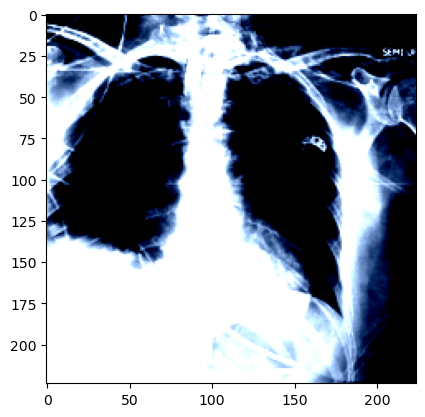

In [30]:
plt.imshow(img.permute(1, 2, 0))

#### 14 disease types

In [21]:
disease_types = list(data[0].keys())[1:]

In [22]:
disease_types

['Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices',
 'No Finding']

In [23]:
img_type_list = []
disease_list = []
for disease_type in disease_types:
    disease_type_list = []
    for label_dict in data:
        for key, value in label_dict.items():
            if key == 'path_to_image':
                img_type_list.append(splitext(value)[0].split('/')[0])
            elif key == disease_type:
                if value is None:
                    disease_type_list.append('None')
                else:
                    disease_type_list.append(value)
    disease_list.append(disease_type_list)

In [24]:
for i, disease_type in enumerate(disease_types):
    print(f'{disease_type}: {np.unique(disease_list[i], return_counts=True)}')

Enlarged Cardiomediastinum: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([  6909,  12928,   4130, 199495]))
Cardiomegaly: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([  1554,  11261,  10971, 199676]))
Lung Opacity: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([   105,   1488,  32358, 189511]))
Lung Lesion: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([   459,    329,   3490, 219184]))
Edema: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([  2687,   4443,  12148, 204184]))
Consolidation: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([  5938,   7083,   4159, 206282]))
Pneumonia: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([  3702,    381,    915, 218464]))
Atelectasis: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([  8371,    167,   9136, 205788]))
Pneumothorax: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([   702,  18577,   6391, 197792]))
Pleural Effusion

#### preset train/test split

In [25]:
np.unique(img_type_list, return_counts=True)

(array(['train', 'valid'], dtype='<U5'), array([3125192,    3276]))

#### patient ids

In [26]:
patient_id_list = [splitext(data[i]['path_to_image'])[0].split('/')[1][7:] for i in range(len(data))]

In [27]:
patient_id, patient_id_count = np.unique(patient_id_list, return_counts=True)

In [28]:
len(patient_id)

64725

Text(0, 0.5, 'x-ray counts')

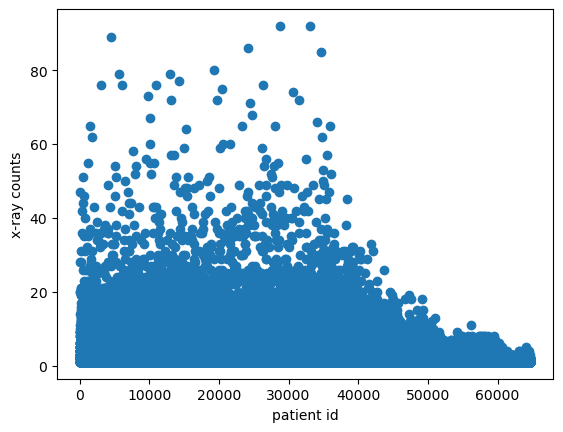

In [30]:
plt.scatter(np.arange(len(patient_id)), patient_id_count)
plt.xlabel('patient id')
plt.ylabel('x-ray counts')

In [31]:
np.argsort(patient_id_count)

array([    0, 43860, 43864, ...,  4461, 33146, 28739])

In [32]:
len(patient_id_count)

64725

In [33]:
patient_id[28739]

'28746'

In [34]:
patient_id_count[28739]

92

In [35]:
type(patient_id_list[0])

str

In [36]:
patient_28739_idx = np.where(np.array(patient_id_list)=='28746')[0]

In [37]:
patient_28739_data = [data[i] for i in patient_28739_idx]

In [38]:
angle_list = []
for patient_28739_d in patient_28739_data:
    angle_list.append(splitext(patient_28739_d['path_to_image'])[0].split('/')[-1][6:])

In [39]:
np.unique(angle_list, return_counts=True)

(array(['frontal', 'lateral'], dtype='<U7'), array([89,  3]))

In [40]:
png_folder = '../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus/PNG'

In [41]:
folders= os.listdir(png_folder)

In [42]:
# Filtering non-zip folders
non_zip_folders = [folder for folder in folders if not folder.endswith('.zip')]

# Iterating over the non-zip folders
for folder in non_zip_folders:
    print(f"Processing folder: {folder}")
    # Your processing code here

Processing folder: png_chexpert_plus_chunk_0
Processing folder: png_chexpert_plus_chunk_1
Processing folder: png_chexpert_plus_chunk_3
Processing folder: png_chexpert_plus_chunk_4
Processing folder: png_chexpert_plus_chunk_2


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CheXpertDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode="train"):
        """
        Args:
            root_dir (str): Path to the parent directory containing subdirectories (e.g., 'png_folder').
            transform (callable, optional): Optional transform to be applied on an image.
            mode (str): Either "train" or "valid" to select the correct folder.
        """
        self.image_paths = []
        self.transform = transform
        self.mode = mode

        # Iterate over each non-zip folder
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)

            if not os.path.isdir(folder_path) or folder.endswith(".zip"):
                continue  # Skip zip files

            # Define train/valid directory path
            mode_dir = os.path.join(folder_path, "PNG", mode)
            if not os.path.exists(mode_dir):
                continue  # Skip if the mode directory doesn't exist

            # Traverse patient folders and study folders
            for patient_folder in os.listdir(mode_dir):
                patient_path = os.path.join(mode_dir, patient_folder)

                if not os.path.isdir(patient_path):
                    continue  # Skip if it's not a directory

                for study_folder in os.listdir(patient_path):
                    study_path = os.path.join(patient_path, study_folder)

                    if not os.path.isdir(study_path):
                        continue  # Skip if it's not a directory

                    # Collect PNG file paths
                    for img_file in os.listdir(study_path):
                        if img_file.endswith(".png"):
                            img_path = os.path.join(study_path, img_file)
                            self.image_paths.append(img_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB

        if self.transform:
            image = self.transform(image)

        return image, img_path  # Return both image tensor and path

# Define transforms for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create dataset and dataloader
dataset = CheXpertDataset(root_dir=png_folder, transform=transform, mode="train")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# Example usage: Iterate over dataset
for images, paths in dataloader:
    print(f"Batch size: {images.shape}, First image path: {paths[0]}")
    break  # Just showing the first batch

In [43]:
import json

import pandas as pd

# Load the CSV file into a DataFrame
path = os.path.join(data_folder,'df_chexpert_plus_240401.csv')
df = pd.read_csv(path)
df = df[df['section_findings'].apply(lambda x: isinstance(x, str) and len(x.split()) >= 2)]

path2 = os.path.join(data_folder,'radgraph-XL-annotations')


In [45]:
df

,path_to_image,path_to_dcm,frontal_lateral,ap_pa,deid_patient_id,patient_report_date_order,report,section_narrative,section_clinical_history,section_history,...,section_accession_number,age,sex,race,ethnicity,interpreter_needed,insurance_type,recent_bmi,deceased,split
8,train/patient04528/study1/view2_lateral.jpg,train/patient04528/study1/view2_lateral.dcm,Lateral,NaN,patient04528,1,NARRATIVE:\nRADIOGRAPHIC EXAMINATION OF THE CH...,\nRADIOGRAPHIC EXAMINATION OF THE CHEST: 6/3/1...,"61 years of age, Female, R o infiltarate..AML...",NaN,...,\nRUFLZXH\nThis report has been anonymized. Al...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,24.9,Yes,train
9,train/patient04528/study1/view1_frontal.jpg,train/patient04528/study1/view1_frontal.dcm,Frontal,PA,patient04528,2,NARRATIVE:\nRADIOGRAPHIC EXAMINATION OF THE CH...,\nRADIOGRAPHIC EXAMINATION OF THE CHEST: 11-28...,"61 years of age, Female, R o infiltarate..AML...",NaN,...,\n716611072\nThis report has been anonymized. ...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,24.9,Yes,train
15,train/patient11162/study3/view1_frontal.jpg,train/patient11162/study3/view1_frontal.dcm,Frontal,AP,patient11162,3,NARRATIVE:\nSINGLE VIEW PORTABLE CHEST: 1-19-2...,\nSINGLE VIEW PORTABLE CHEST: 1-19-2015\n,61-year-old man with history of heart\ntransp...,NaN,...,\nYcxarrDeV\nThis report has been anonymized. ...,62.0,Male,Asian,Non-Hispanic/Non-Latino,No,Medicare,16.9,No,train
16,train/patient11162/study5/view1_frontal.jpg,train/patient11162/study5/view1_frontal.dcm,Frontal,PA,patient11162,6,NARRATIVE:\nTWO VIEWS OF THE CHEST 21 SEPTEMBE...,\nTWO VIEWS OF THE CHEST 21 SEPTEMBER:\n,61 year-old man status post heart transplant.\n,NaN,...,\n04979080\nThis report has been anonymized. A...,62.0,Male,Asian,Non-Hispanic/Non-Latino,No,Medicare,16.9,No,train
20,train/patient11162/study5/view2_lateral.jpg,train/patient11162/study5/view2_lateral.dcm,Lateral,NaN,patient11162,7,NARRATIVE:\nTWO VIEWS OF THE CHEST 11-3-2010:\...,\nTWO VIEWS OF THE CHEST 11-3-2010:\n,61 year-old man status post heart transplant.\n,NaN,...,\n34087935384\nThis report has been anonymized...,62.0,Male,Asian,Non-Hispanic/Non-Latino,No,Medicare,16.9,No,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223444,train/patient64366/study1/view1_frontal.jpg,train/patient64366/study1/view1_frontal.dcm,Frontal,AP,patient64366,1,NARRATIVE:\nRADIOGRAPHIC EXAMINATION OF THE CH...,\nRADIOGRAPHIC EXAMINATION OF THE CHEST POST N...,"67 years of age, Male, Status post right lowe...",NaN,...,\n9161884498\nThis report has been anonymized....,68.0,Male,Asian,Non-Hispanic/Non-Latino,No,Unknown,26.1,No,train
223449,train/patient33118/study1/view1_frontal.jpg,train/patient33118/study1/view1_frontal.dcm,Frontal,AP,patient33118,1,"NARRATIVE:\nPORTABLE CHEST, SINGLE VIEW: 12-17...","\nPORTABLE CHEST, SINGLE VIEW: 12-17-2005.\n",NaN,NaN,...,\n6843-8056\nThis report has been anonymized. ...,62.0,Male,White,Non-Hispanic/Non-Latino,Unknown,Private Insurance,NaN,Yes,train
223454,train/patient22453/study1/view1_frontal.jpg,train/patient22453/study1/view1_frontal.dcm,Frontal,AP,patient22453,1,NARRATIVE:\nAP UPRIGHT VIEW OF THE CHEST: 6-...,\nAP UPRIGHT VIEW OF THE CHEST: 6-29-09 at 1...,A 30-year-old male with achalasia. Rule o...,NaN,...,\n#qvo3lgfor\nThis report has been anonymized....,30.0,Male,Other,Non-Hispanic/Non-Latino,No,Unknown,21.6,No,train
223456,train/patient33763/study1/view1_frontal.jpg,train/patient33763/study1/view1_frontal.dcm,Frontal,AP,patient33763,1,NARRATIVE:\nChest 1 View: 3/19/01\n \nHISTORY:...,\nChest 1 View: 3/19/01\n \n,NaN,"64 years Male, Abrasion to upper back.\n \n",...,\n#21615021279\nThis report has been anonymize...,64.0,Male,White,Non-Hispanic/Non-Latino,No,Private Insurance,NaN,No,train
